In [ ]:
!wget https://www.dropbox.com/s/xu7ihii47ys6lkk/hackathons.tar?dl=0

--2020-09-10 06:39:46--  https://www.dropbox.com/s/xu7ihii47ys6lkk/hackathons.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xu7ihii47ys6lkk/hackathons.tar [following]
--2020-09-10 06:39:47--  https://www.dropbox.com/s/raw/xu7ihii47ys6lkk/hackathons.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0eefe547efd4e8a633985cc097.dl.dropboxusercontent.com/cd/0/inline/A_HmIRryToGUdN1ymtq3DHCiFfva-3EN9FH4DpSpez1hJS0MpqI00Zb78m46v4crIXkUElP_8BtIeqUDak6H0bz_pmaIINBdUgwX1ZI3l8FE_0Mq_MrFFYacGJEs8TQAvVc/file# [following]
--2020-09-10 06:39:47--  https://uc0eefe547efd4e8a633985cc097.dl.dropboxusercontent.com/cd/0/inline/A_HmIRryToGUdN1ymtq3DHCiFfva-3EN9FH4DpSpez1hJS0MpqI00Zb78m46v4crIXkUElP_8BtIeqUDak6H0bz_pmaIINBdUgwX1ZI

In [ ]:
import shutil
shutil.unpack_archive("/content/hackathons.tar", "/content/hackathons")

In [1]:
import os
print(os.getcwd())

/content


In [2]:
os.chdir("/content/hackathons/hackathons/hackathon_1")

In [3]:
print(os.getcwd())
print(os.listdir())

/content/hackathons/hackathons/hackathon_1
['sample_submission_yxjOnvz.csv', 'images', 'tmp', 'nonemer_source', 'sample_submission.csv', 'images.zip', 'test.csv', 'code.ipynb', 'emer_source', 'train.csv']


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import os
import pandas as pd
from shutil import copyfile
import random
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
working_dir = os.getcwd()
print(working_dir)
# dataframe for train.csv
train_df = pd.read_csv(working_dir+'/train.csv')
# dataframe for test.csv
test_df = pd.read_csv(working_dir+'/test.csv')

/content/hackathons/hackathons/hackathon_1


In [6]:
print(train_df.head())
print(test_df.head())

  image_names  emergency_or_not
0    1503.jpg                 0
1    1420.jpg                 0
2    1764.jpg                 0
3    1356.jpg                 0
4    1117.jpg                 0
  image_names
0    1960.jpg
1     668.jpg
2    2082.jpg
3     808.jpg
4    1907.jpg


In [7]:
# 2352 total images
print(len(os.listdir(working_dir+'/images')))

2352


In [8]:
# create folders
to_create = [
    working_dir+'/emer_source',
    working_dir+'/nonemer_source',
    working_dir+'/tmp',
    working_dir+'/tmp/emer-v-nonemer',
    working_dir+'/tmp/emer-v-nonemer/training',
    working_dir+'/tmp/emer-v-nonemer/testing',
    working_dir+'/tmp/emer-v-nonemer/training/emer',
    working_dir+'/tmp/emer-v-nonemer/training/nonemer',
    working_dir+'/tmp/emer-v-nonemer/testing/emer',
    working_dir+'/tmp/emer-v-nonemer/testing/nonemer'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/content/hackathons/hackathons/hackathon_1/emer_source failed
/content/hackathons/hackathons/hackathon_1/nonemer_source failed
/content/hackathons/hackathons/hackathon_1/tmp failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/training failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/testing failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/training/emer failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/training/nonemer failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/testing/emer failed
/content/hackathons/hackathons/hackathon_1/tmp/emer-v-nonemer/testing/nonemer failed


In [9]:
emer_training = working_dir+'/tmp/emer-v-nonemer/training/emer/'
nonemer_training = working_dir+'/tmp/emer-v-nonemer/training/nonemer/'
emer_testing = working_dir+'/tmp/emer-v-nonemer/testing/emer/'
nonemer_testing = working_dir+'/tmp/emer-v-nonemer/testing/nonemer/'

In [10]:
print(train_df['image_names'][0])
print(train_df['emergency_or_not'][0])
print(test_df['image_names'][0])

print(train_df.iloc[0])

1503.jpg
0
1960.jpg
image_names         1503.jpg
emergency_or_not           0
Name: 0, dtype: object


In [11]:
# separate dataframes for emergency and nonemergency images in training set
training_emer = train_df.loc[train_df['emergency_or_not']==0]
training_nonemer = train_df.loc[train_df['emergency_or_not']==1]

In [ ]:
for i in training_emer['image_names']:
    image_name = i
    copyfile(working_dir+'/images/'+i, working_dir+'/emer_source/'+i)
    
for i in training_nonemer['image_names']:
    image_name = i
    copyfile(working_dir+'/images/'+i, working_dir+'/nonemer_source/'+i)

In [12]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

emer_source_dir = (working_dir+'/emer_source/')
train_emer_dir = emer_training
test_emer_dir = emer_testing

nonemer_source_dir = (working_dir+'/nonemer_source/')
train_nonemer_dir = nonemer_training
test_nonemer_dir = nonemer_testing

split_size = .9
split_data(emer_source_dir, train_emer_dir, test_emer_dir, split_size)
split_data(nonemer_source_dir, train_nonemer_dir, test_nonemer_dir, split_size)

In [13]:
print(len(os.listdir(emer_source_dir)))
print(len(os.listdir(nonemer_source_dir)))

965
681


In [14]:
print(len(os.listdir(train_emer_dir)))
print(len(os.listdir(test_emer_dir)))
print('-----')
print(len(os.listdir(train_nonemer_dir)))
print(len(os.listdir(test_nonemer_dir)))

959
188
-----
675
132


In [15]:
import cv2
image = cv2.imread(working_dir+'/images/0.jpg')

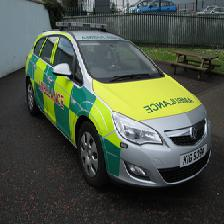

In [16]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [17]:
print(image.shape)

(224, 224, 3)


In [ ]:
# Model 1
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# # Model 2
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
TRAINING_DIR = working_dir+'/tmp/emer-v-nonemer/training'
# train_datagen = ImageDataGenerator(rescale = 1. / 255)

train_datagen = ImageDataGenerator(
      rescale=1. /255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(224, 224)
)

VALIDATION_DIR = working_dir+'/tmp/emer-v-nonemer/testing'
validation_datagen = ImageDataGenerator(rescale= 1. /255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(224, 224)
)

Found 1480 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

warnings ignored


In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 16s 648ms/step - loss: 0.2625 - acc: 0.8953 - val_loss: 0.6131 - val_acc: 0.8494
Epoch 2/10
24/24 [==============================] - 15s 645ms/step - loss: 0.2865 - acc: 0.8831 - val_loss: 0.4138 - val_acc: 0.8494
Epoch 3/10
24/24 [==============================] - 16s 649ms/step - loss: 0.2704 - acc: 0.8878 - val_loss: 1.6419 - val_acc: 0.7229
Epoch 4/10
24/24 [==============================] - 16s 668ms/step - loss: 0.2820 - acc: 0.8757 - val_loss: 0.3987 - val_acc: 0.8916
Epoch 5/10
24/24 [==============================] - 15s 642ms/step - loss: 0.2654 - acc: 0.8824 - val_loss: 0.9178 - val_acc: 0.8434
Epoch 6/10
24/24 [==============================] - 15s 645ms/step - loss: 0.2705 - acc: 0.8885 - val_loss: 0.4794 - val_acc: 0.8675
Epoch 7/10
24/24 [==============================] - 15s 644ms/step - loss: 0.2691 - acc: 0.8939 - val_loss: 0.5730 - val_acc: 0.8735
Epoch 8/10
24/24 [==============================] - 16s 647ms/step - 

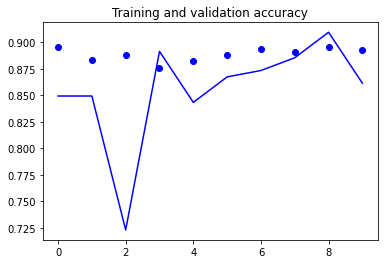

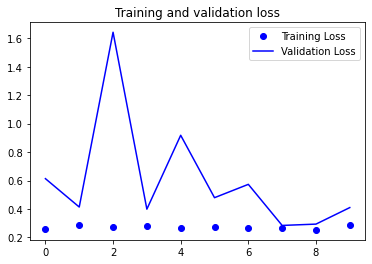

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predicting images
print(test_df.head())

  image_names
0    1960.jpg
1     668.jpg
2    2082.jpg
3     808.jpg
4    1907.jpg


In [ ]:
from keras.preprocessing import image
import numpy as np

In [ ]:
predictions = []
for name in test_df['image_names']:
  # print(name)
  path = '/content/hackathons/hackathons/hackathon_1/images/' + name
  img = image.load_img(path, target_size=((224, 224)))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(name + " is a emergency vehicle")
    predictions.append(1)
  else:
    print(name + " is a non-emergency vehicle")
    predictions.append(0)

In [ ]:
# test_df
# len(predictions)
sample_submission = test_df
sample_submission['emergency_or_not'] = predictions

In [ ]:
sample_submission.to_csv('sample_submission.csv')

#TRANSFER LEARNING

In [18]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-10 08:55:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   134MB/s    in 0.6s    

2020-09-10 08:55:22 (134 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [59]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions



# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [20]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 12, 12, 768)


In [21]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [42]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)   

#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.005), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [43]:
# # Model 2
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [44]:
TRAINING_DIR = working_dir+'/tmp/emer-v-nonemer/training'
# train_datagen = ImageDataGenerator(rescale = 1. / 255)

train_datagen = ImageDataGenerator(
      rescale=1. /255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(224, 224)
)

VALIDATION_DIR = working_dir+'/tmp/emer-v-nonemer/testing'
validation_datagen = ImageDataGenerator(rescale= 1. /255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(224, 224)
)

Found 1634 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [45]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

warnings ignored


In [72]:
# callbacks = myCallback()

history = model.fit_generator(
    train_generator,
    epochs=40,
    verbose=1,
    validation_data=validation_generator,
)

Epoch 1/40
26/26 [==============================] - 18s 683ms/step - loss: 0.1687 - accuracy: 0.9419 - val_loss: 0.0746 - val_accuracy: 0.9812
Epoch 2/40
26/26 [==============================] - 18s 677ms/step - loss: 0.1737 - accuracy: 0.9455 - val_loss: 0.0727 - val_accuracy: 0.9781
Epoch 3/40
26/26 [==============================] - 18s 678ms/step - loss: 0.1421 - accuracy: 0.9474 - val_loss: 0.0875 - val_accuracy: 0.9719
Epoch 4/40
26/26 [==============================] - 18s 679ms/step - loss: 0.1939 - accuracy: 0.9321 - val_loss: 0.0781 - val_accuracy: 0.9750
Epoch 5/40
26/26 [==============================] - 18s 683ms/step - loss: 0.1442 - accuracy: 0.9449 - val_loss: 0.0773 - val_accuracy: 0.9656
Epoch 6/40
26/26 [==============================] - 18s 677ms/step - loss: 0.1836 - accuracy: 0.9370 - val_loss: 0.0686 - val_accuracy: 0.9781
Epoch 7/40
26/26 [==============================] - 18s 680ms/step - loss: 0.1402 - accuracy: 0.9529 - val_loss: 0.0703 - val_accuracy: 0.9781

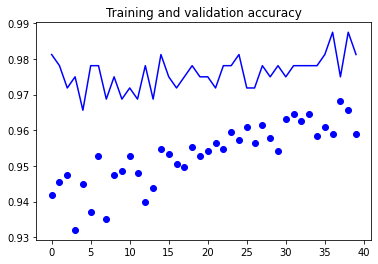

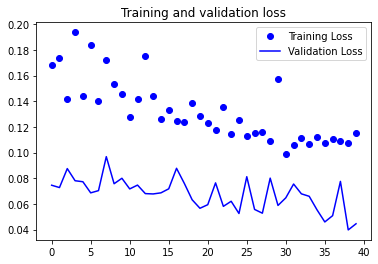

In [73]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
from keras.preprocessing import image
import numpy as np
predictions = []
for name in test_df['image_names']:
  # print(name)
  path = '/content/hackathons/hackathons/hackathon_1/images/' + name

  # load an image from file
  image = load_img(path, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)
  # predict the probability across all output classes
  yhat = model.predict(image)
  print(yhat[0][0])
  if (yhat[0][0]>0.5):
    predictions.append(1)
  else:
    predictions.append(0)

2.1982736e-05
1.0
1.9222124e-07
1.0
8.271157e-05
0.99975306
0.0029014177
1.0
5.697177e-05
0.68310326
1.5778534e-06
0.0001416274
0.00256472
9.389114e-07
1.7871985e-06
1.0
0.00079891837
0.98307
0.997743
0.9999621
0.99999976
0.00015999688
0.27516228
3.4721164e-05
0.00012852262
0.009800937
0.9999603
9.8041895e-08
0.059038
0.82856
0.9998141
0.00026641894
0.9973369
0.00020012658
0.004468728
0.0012968114
0.8531799
1.0
9.88167e-05
3.8447895e-05
1.0
0.7332501
0.00038700528
0.050647214
0.038549222
0.21717755
0.0020812124
4.01366e-07
0.00040012333
0.00017290212
1.0
0.9272578
7.189474e-05
0.0047640093
0.9999999
0.00028108808
1.0
0.93086445
0.0008068168
0.0008362855
0.99999976
1.0
0.00012918143
0.04987465
1.0
0.022648467
0.99993277
0.8601232
0.79368895
5.474176e-05
0.0013759853
0.00093537563
1.0
0.09973334
0.836483
0.00034046406
0.20499642
0.912111
0.9998325
1.0
0.00018683153
0.9999989
0.99662507
0.7414099
0.00075369864
0.000114394104
0.000883561
1.0
0.9843105
1.0
0.0002819483
0.039947983
0.0070023

In [75]:
test_df
# len(predictions)
sample_submission = test_df
sample_submission['emergency_or_not'] = predictions

In [76]:
sample_submission.to_csv('sample_submission.csv')

1412